Notebook dédié à la prédiction de la cohésine sur l'ensemble du génome de levure mais aussi sur le génome de bactérie introduite dans le génome de levure.

In [1]:
from keras_dna import Generator, ModelWrapper
import tensorflow.keras as keras
import numpy as np
import pyBigWig
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import itertools

In [2]:
from MyModuleLibrary.mykeras.losses import mae_cor, correlate
from MyModuleLibrary.array_modifier import rolling_window

In [3]:
def one_hot_encoder(nucleotid):
    res = (np.arange(4) == nucleotid[..., None]-1).astype(int)
    res = res.reshape(res.shape[0], 4)
    return res

In [4]:
import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)

# Predictions

In [17]:
! cp ../Projet_cohesine/results/weights_myco_rep3.hdf5 ./models/weights_myco_rep1_cohesine_3.hdf5

In [18]:
model = keras.models.load_model('./models/weights_myco_rep1_cohesine_3.hdf5', custom_objects={'correlate' : correlate})

generator_train = Generator(batch_size=64,
                            fasta_file='./data/W303.fa',
                            annotation_files=['../Projet_cohesine/data/pneu_coverage_rep1.bw'],
                            size='./data/sacCer3.chrom.sizes',
                            window=32768,
                            tg_window=256,
                            downsampling='mean',
                            overlapping=10,
                            normalization_mode='max',
                            weighting_mode=([[-0.2, 0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 1.0]],
                                            [[1, 4, 10, 20, 30, 40, 50]]),
                            incl_chromosomes=['chr01'],
                            output_shape=(64, 256, 1))

wrap = ModelWrapper(model=model,
                    generator_train=generator_train,
                    validation_chr=['chr15', 'chr16'],
                    weights_val=True)

wrap.predict(incl_chromosomes=['chr01', 'chr02', 'chr03', 'chr04',
                               'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                               'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16'],
             chrom_size='./data/W303.chrom.sizes',
             export_to_path='./results/yeast/cohesine_myco_3')

array([[[0.8446906 ],
        [0.95868766],
        [1.0125226 ],
        ...,
        [1.1311889 ],
        [0.98973393],
        [1.0531971 ]],

       [[0.9296718 ],
        [1.0279369 ],
        [0.863438  ],
        ...,
        [1.2961327 ],
        [1.2769892 ],
        [1.1334598 ]],

       [[1.9416955 ],
        [2.2134285 ],
        [2.4267843 ],
        ...,
        [0.84204906],
        [0.821316  ],
        [0.76721823]],

       ...,

       [[0.6902256 ],
        [0.7023225 ],
        [0.70210665],
        ...,
        [2.3663733 ],
        [2.5334797 ],
        [2.5136049 ]],

       [[1.3077018 ],
        [1.1922389 ],
        [1.3623164 ],
        ...,
        [1.1382732 ],
        [1.2589726 ],
        [1.1543751 ]],

       [[0.5326507 ],
        [0.5376251 ],
        [0.5900322 ],
        ...,
        [1.2031138 ],
        [1.3294884 ],
        [1.2724562 ]]], dtype=float32)

In [5]:
WINDOW = 32768

In [20]:
def prepare_input(pathname):
    seq_chr = np.array(h5py.File(pathname, 'r')['data'])[:, 0]
    
    if len(seq_chr) < WINDOW:
        padding = (WINDOW - len(seq_chr)) // 2
        adder = (len(seq_chr) - WINDOW) % 2
        seq_chr = np.concatenate([np.zeros(padding), seq_chr, np.zeros(padding + adder)])
        print(len(seq_chr))
        
    seq_chr[seq_chr == 2] = 5
    seq_chr[seq_chr == 4] = 2
    seq_chr[seq_chr == 5] = 4
    seq_chr_onehot = one_hot_encoder(seq_chr)
    X = rolling_window(seq_chr_onehot, (WINDOW, 4), (WINDOW, 4))[:, 0, :, :]
    return X

In [21]:
y_pred = model.predict(prepare_input('./data/bacterie/Mmm_Linear_740kb.hdf5'))
prediction = np.zeros((1222199,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
prediction[:len(y_pred)] = y_pred
np.save('./results/bacterial/cohesine_myco_3.npy', prediction)

In [22]:
y_pred = model.predict(prepare_input('./data/bacterie/Pneu300.hdf5'))
prediction = np.zeros((817946,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
prediction[:len(y_pred)] = y_pred
np.save('./results/bacterial/cohesine_pneu_3.npy', prediction)

# Représentation sur l'ensemble du génome

In [6]:
yeast_sizes = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chr', 'size'])
yeast_sizes = {chrom : size for chrom, size in yeast_sizes.values}

myco_sizes = pd.read_csv('./data/bacterie/Mmm_Linear_740kb.chrom.sizes', sep='\t', names=['chr', 'size'])
myco_sizes = {chrom : size for chrom, size in myco_sizes.values}

pneu_sizes = pd.read_csv('./data/bacterie/Pneu300.chrom.sizes', sep='\t', names=['chr', 'size'])
pneu_sizes = {chrom : size for chrom, size in pneu_sizes.values}

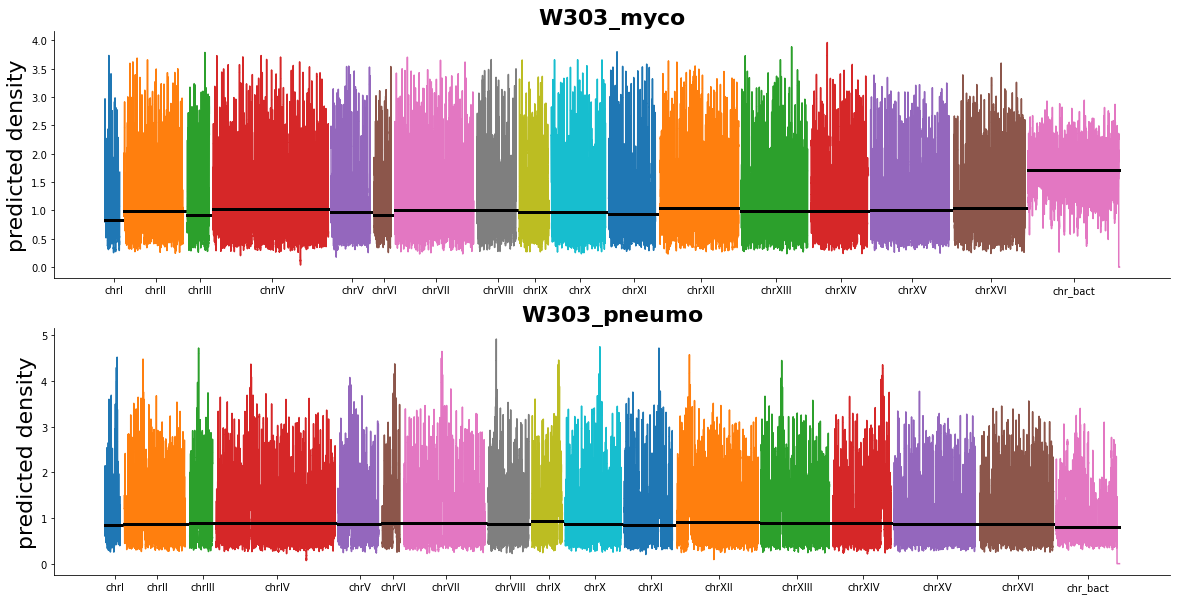

In [230]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []


bw = pyBigWig.open("./results/yeast/cohesine_myco_cell_number0_annotation_number0.bw")

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']:
    
    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/cohesine_myco.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction)
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('predicted density', fontsize=22)
#ax.set_ylim([0, 0.01])

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/cohesine_pneu_cell_number0_annotation_number0.bw")

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']:

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/cohesine_pneu.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction)
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('predicted density', fontsize=22)
ax.set_ylim([0, 0.01])

fig.savefig('./results/cohesine_density.png')

In [11]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_RPKM35.bed')
myco_coverage_rep2 = read_bed('./data/for_Julien/myco/coverage_RPKM38.bed')

pneu_coverage_rep1 = read_bed('./data/for_Julien/pneumo/coverage_RPKM219.bed')
pneu_coverage_rep2 = read_bed('./data/for_Julien/pneumo/coverage_RPKM220.bed')

In [7]:
def log(x):
    x_ = np.copy(x)
    x_[np.isnan(x_)] = 0
    x_[np.isinf(x_)] = np.percentile(x_, 99.5)
    x_[np.isinf(x_)] = np.percentile(x_, 90)
    x_ = np.log2(x_ + 1)
    return x_

NameError: name 'myco_coverage_rep1' is not defined

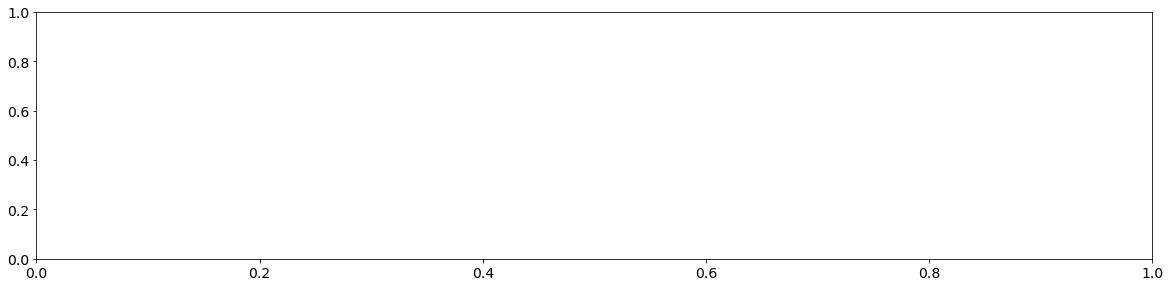

In [6]:
fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Mmm_Linear_740kb.fa']:

    prediction = log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=22)
ax.set_ylabel('cohesine density', fontsize=22)
#ax.set_ylim([-0.05, 1])

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
              'Pneu300']:
    
    prediction = log(pneu_coverage_rep1[chrom] / pneu_coverage_rep2[chrom]) 
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction)
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=22)
ax.set_ylabel('cohesine density', fontsize=22)
#ax.set_ylim([-0.05, 1])

fig.savefig('./results/cohesine_density_experimental.png')

## Reprise des figures

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as a

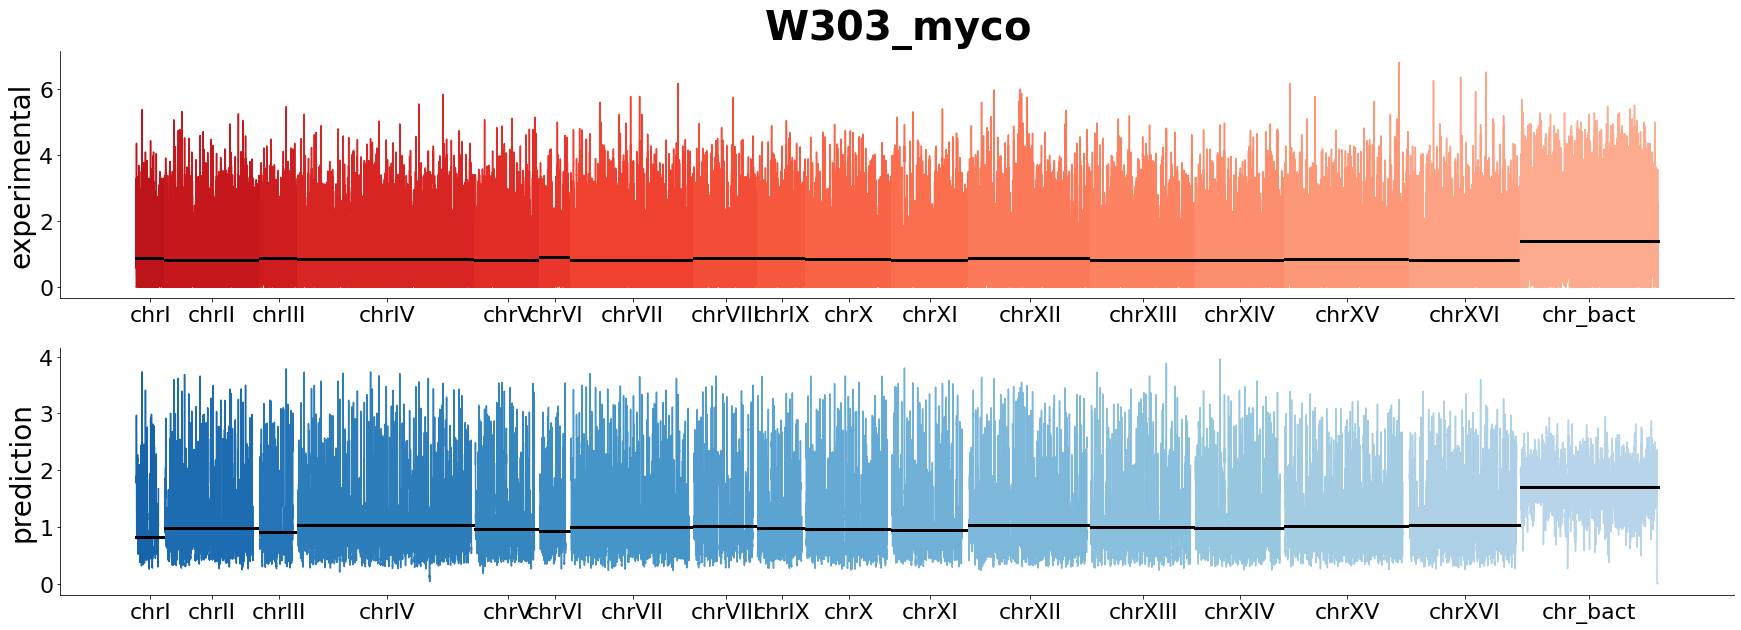

In [345]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Mmm_Linear_740kb.fa']):

    prediction = log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_myco}$', fontsize=40)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/cohesine_myco_cell_number0_annotation_number0.bw")
colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                           'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                           'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']):

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/cohesine_myco.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction, color=colors[-1])
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/cohesine_myco_whole_genome.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as a

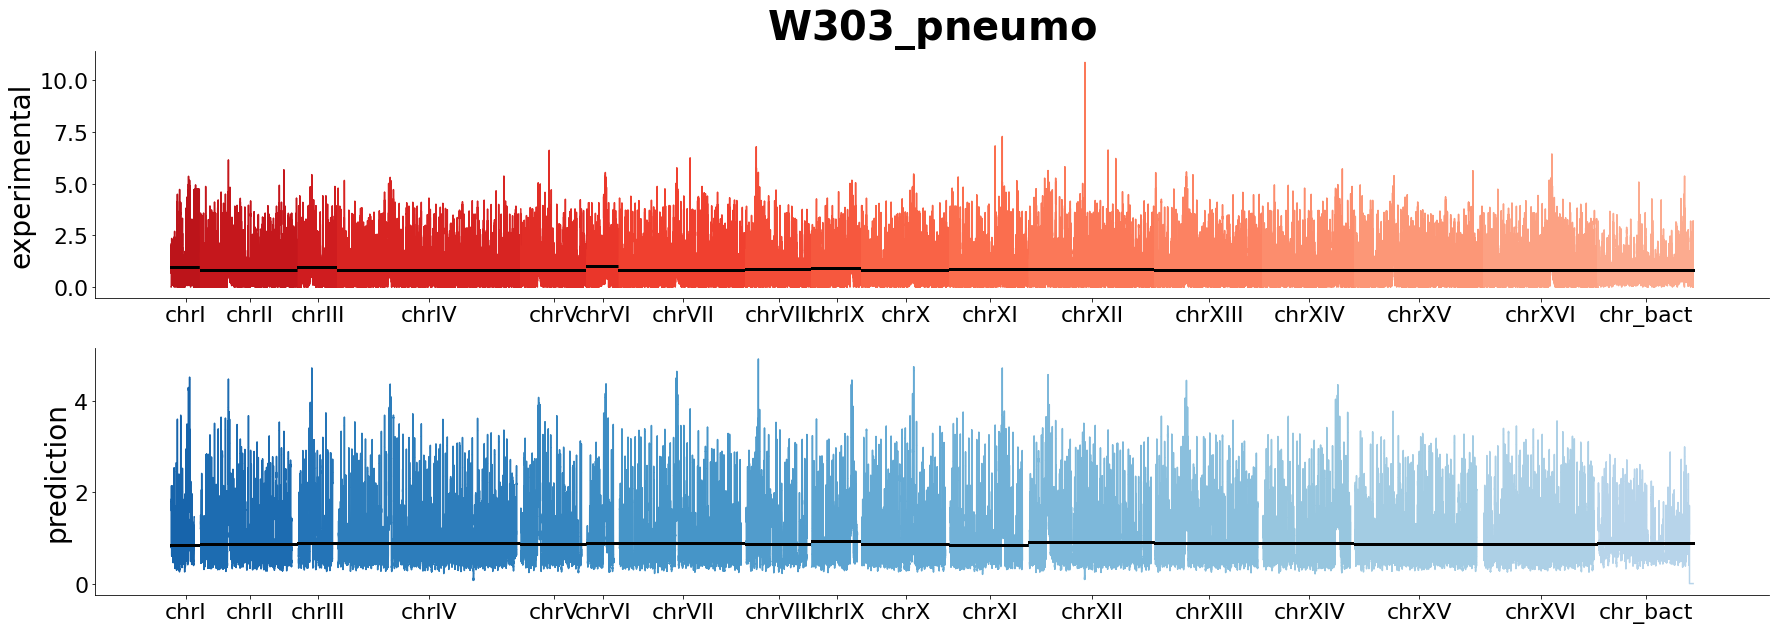

In [346]:
fig = plt.figure(figsize=(30, 10))

ax = fig.add_subplot(2, 1, 1)
start = 0
stop = 0
xticks = []

colors = plt.cm.Reds_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                          'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                          'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16',
                          'Pneu300']):

    prediction = log(pneu_coverage_rep1[chrom] / pneu_coverage_rep2[chrom])
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_title(r'$\bf{W303\_pneumo}$', fontsize=40)
ax.set_ylabel('experimental', fontsize=28)

ax = fig.add_subplot(2, 1, 2)
start = 0
stop = 0
xticks = []

bw = pyBigWig.open("./results/yeast/cohesine_pneu_cell_number0_annotation_number0.bw")
colors = plt.cm.Blues_r(np.linspace(0.2, 0.7, 17))

for i, chrom in enumerate(['chr01', 'chr02', 'chr03', 'chr04',
                           'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                           'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']):

    prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
    stop += len(prediction)
    xticks.append((stop + start) // 2)
    ax.plot(np.arange(start, stop), prediction, color=colors[i])
    prediction[np.isnan(prediction)] = 0
    ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
    start += len(prediction)

bw.close()

prediction = np.load('./results/bacterial/cohesine_pneu.npy')
stop += len(prediction)
xticks.append((stop + start) // 2)
ax.plot(np.arange(start, stop), prediction, color=colors[-1])
ax.plot([start, stop], [np.mean(prediction), np.mean(prediction)], 'k', linewidth=3)
start += len(prediction)
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xticks)
ax.set_xticklabels(['chrI', 'chrII', 'chrIII', 'chrIV', 'chrV', 'chrVI', 'chrVII', 'chrVIII', 'chrIX',
                    'chrX', 'chrXI', 'chrXII', 'chrXIII', 'chrXIV', 'chrXV', 'chrXVI', 'chr_bact'])
ax.set_ylabel('prediction', fontsize=28)

fig.savefig('./results/cohesine_pneu_whole_genome.png')

# Comparison avec les données expérimentales

In [8]:
roman_to_num = {'chrI' : 'chr01', 'chrII' : 'chr02', 'chrIII' : 'chr03', 'chrIV' : 'chr04', 'chrV' : 'chr05',
                'chrVI' : 'chr06', 'chrVII' : 'chr07', 'chrVIII' : 'chr08', 'chrIX' : 'chr09', 'chrX' : 'chr10', 'chrXI' : 'chr11',
                'chrXII' : 'chr12', 'chrXIII' : 'chr13', 'chrXIV' : 'chr14', 'chrXV' : 'chr15', 'chrXVI' : 'chr16', 'chrM' : 'chrM'} 

In [9]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom : size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}
chrom_size['Mmm_Linear_740kb.fa'] = 1222199
chrom_size['Pneu300'] = 817946

### Préparation des données normalisées

In [18]:
chrom_size = pd.read_csv('./data/W303.chrom.sizes', sep='\t', names=['chrom', 'sizes'])
chrom_size = {chrom : size for chrom, size in zip(chrom_size.chrom.values, chrom_size.sizes.values)}

bw = pyBigWig.open('../Projet_cohesine/data/pneu_coverage_log_cpm.bw', 'w')
bw.addHeader([(chrom, size) for chrom, size in chrom_size.items()])

for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']:
    prediction = log(pneu_coverage_rep1[chrom]) - log(pneu_coverage_rep2[chrom])
    bw.addEntries(chrom, np.arange(0, len(prediction)), values=prediction, span=1)
    
bw.close()

In [10]:
def read_bed(pathname):
    df = pd.read_csv(pathname, names=['chrom', 'start', 'stop', 'density'], sep='\t')
    coverages = dict()
    for chrom in df.chrom.unique():
        if chrom in chrom_size:
            local_df = df[df.chrom == chrom]
            coverage = np.zeros(chrom_size[chrom])
            
            for start, stop, density in zip(local_df.start.values, local_df.stop.values, local_df.density.values):
                coverage[start : stop] = density
            coverages[chrom] = coverage
    
    all_coverage = np.concatenate([coverage for _, coverage in coverages.items()])
    threshold = np.sum(all_coverage) / 1000000.
    
    for chrom, coverage in coverages.items():
        coverages[chrom] = coverage / threshold
    return coverages

### Myco

In [239]:
num_to_roman = {value : key for key, value in roman_to_num.items()}

In [251]:
prediction = np.load('./results/bacterial/cohesine_myco.npy')

In [252]:
myco_coverage_rep1 = read_bed('./data/for_Julien/myco/coverage_RPKM35.bed')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


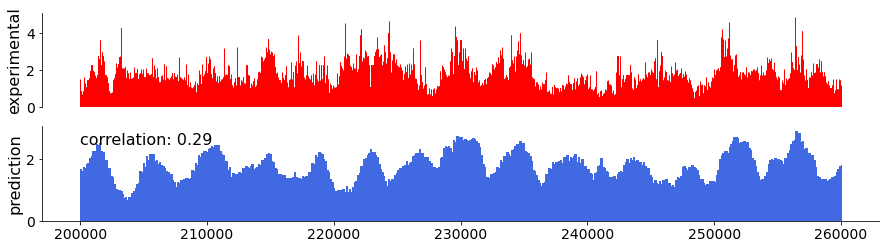

In [253]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)


ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_xticks([])
ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/cohesine_exp_vs_pred_myco_rep1.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


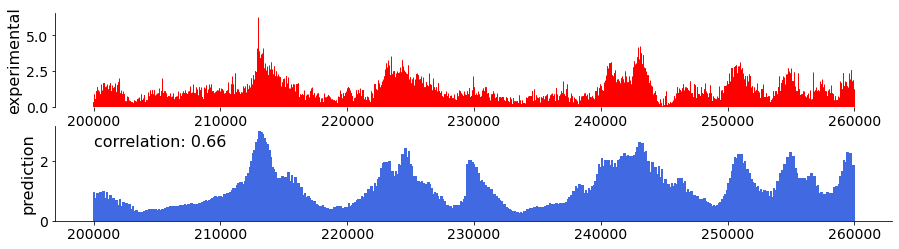

In [254]:
bw = pyBigWig.open("./results/yeast/cohesine_myco_cell_number0_annotation_number0.bw")
prediction = np.array(bw.values('chr16', 0, yeast_sizes['chr16']))
prediction[np.isnan(prediction)] = 0
bw.close()

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['chr16'] / myco_coverage_rep2['chr16'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/cohesine_exp_vs_pred_myco_rep1_chr16.png')

### Pneumo

In [255]:
prediction = np.load('./results/bacterial/cohesine_pneu.npy')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


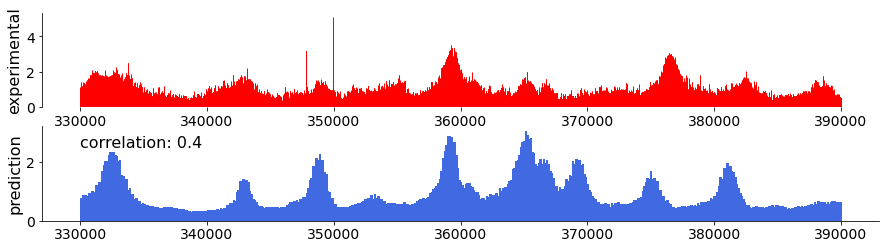

In [256]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 330000
stop = 390000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/cohesine_exp_vs_pred_pneu_rep1.png')

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


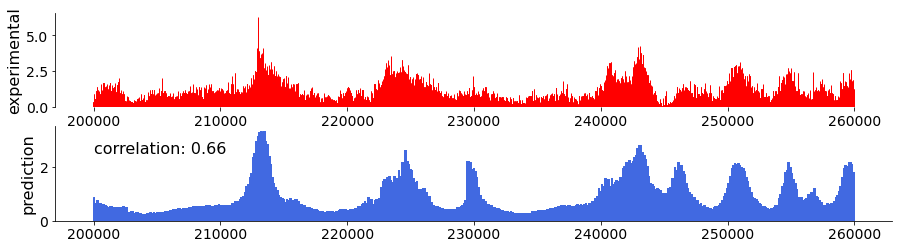

In [257]:
bw = pyBigWig.open("./results/yeast/cohesine_pneu_cell_number0_annotation_number0.bw")
prediction = np.array(bw.values('chr16', 0, yeast_sizes['chr16']))
prediction[np.isnan(prediction)] = 0
bw.close()

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(4, 1, 2)
start = 200000
stop = 260000

#ax.set_ylim([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.plot(np.arange(start, stop), prediction[start : stop], color='royalblue')
ax.bar(x=np.arange(start, stop), height=prediction[start : stop], width=1, edgecolor='royalblue')
ax.set_facecolor('w')
#ax.set_xticks(np.arange(start, stop + 1, 10000))
#ax.set_xticklabels(np.arange(start, stop + 1, 10000), fontsize=14)
#ax.set_yticks(np.arange(0, 1.1, 0.5))
#ax.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
ax.set_ylabel('prediction', fontsize=16)
experimental = log(myco_coverage_rep1['chr16'] / myco_coverage_rep2['chr16'])
ax.text(x=start,
        y=2.5,
        s='correlation: {}'.format(np.round(np.corrcoef(experimental, prediction)[0, 1], 2)),
        fontsize=16)

ax1 = fig.add_subplot(4, 1, 1)
#ax1.set_ylim([0, 1])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#ax1.set_xticks([])
#ax1.set_xticklabels([])
#ax1.set_yticks(np.arange(0, 1.1, 0.5))
#ax1.set_yticklabels(np.arange(0, 1.1, 0.5), fontsize=14)
#ax1.plot(np.arange(start, stop), experimental[start : stop], color='r')
ax1.bar(x=np.arange(start, stop), height=experimental[start : stop], width=1, edgecolor='r')
ax1.set_facecolor('w') 
ax1.set_ylabel('experimental', fontsize=16)

fig.savefig('./results/cohesine_exp_vs_pred_pneu_rep1_chr16.png')

### Evaluation of the mean prediction with the CG-content

In [24]:
y_pred = model.predict(prepare_input('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5'))
prediction = np.zeros((WINDOW,))
y_pred = np.concatenate([np.concatenate(pred) for pred in np.tile(y_pred, [1, 1, 128])])
prediction[:len(y_pred)] = y_pred
np.save('./results/covid19/cohesine_coverage_3.npy', prediction)

32768


In [13]:
def random_sequence(gc=0.4, batch_size=32):
    return np.concatenate([one_hot_encoder(np.random.choice([1, 2, 3, 4],
                                                     WINDOW,
                                                     p=[0.5 - gc / 2., gc / 2., gc / 2., 0.5 - gc / 2.]))[None, ...]\
                                   for _ in range(batch_size)], axis=0)

def get_gc_content(filename):
    seq_chr = np.array(h5py.File(filename, 'r')['data'])[:, 0]
    return get_gc_content_(seq_chr)
    
def get_gc_content_(seq_chr):
    gc_content = np.unique(seq_chr, return_counts=True)[1]
    
    if len(gc_content) == 5:
        return np.sum(gc_content[3:]) / len(seq_chr)
    else:
        return np.sum(gc_content[2:]) / len(seq_chr)


def return_true(chrom):
    output = []
    for file in ['./results/yeast/cohesine_myco_2_cell_number0_annotation_number0.bw',
                 './results/yeast/cohesine_myco_3_cell_number0_annotation_number0.bw',
                 './results/yeast/cohesine_myco_cell_number0_annotation_number0.bw']:
        bw = pyBigWig.open(file)
        if chrom < 10:
            chrom_ = '0' + str(chrom)
        else:
            chrom_ = str(chrom)
        prediction = np.array(bw.values('chr' + str(chrom_), 0, yeast_sizes['chr' + str(chrom_)]))
        prediction[np.isnan(prediction)] = 0
        bw.close()
        output.append(prediction)
    return np.concatenate(output)

In [14]:
models = [keras.models.load_model('./models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate' : correlate}),
          keras.models.load_model('./models/weights_myco_rep1_cohesine_2.hdf5', custom_objects={'correlate' : correlate}),
          keras.models.load_model('./models/weights_myco_rep1_cohesine_3.hdf5', custom_objects={'correlate' : correlate})]

In [15]:
means = [np.mean(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]
stds = [np.std(np.concatenate([model.predict(random_sequence(gc=gc)) for model in models])) for gc in np.arange(0, 1.05, 0.05)]

In [16]:
gc_content_yeast = np.mean([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5') for i in range(1,17)])
mean_coverage_yeast = np.mean(np.concatenate([return_true(i) for i in range(1,17)]))
std_coverage_yeast = np.std(np.concatenate([return_true(i) for i in range(1,17)]))

In [17]:
df_artificial = pd.DataFrame({'species' : np.repeat('artificial', len(means)),
                   'type' : np.repeat('predicted', len(means)),
                   'mean' : means,
                   'std' : stds,
                   'gc' : np.arange(0, 1.05, 0.05)})

df_mmm_pred = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/cohesine_myco.npy'),
                                     np.load('./results/bacterial/cohesine_myco_2.npy'),
                                     np.load('./results/bacterial/cohesine_myco_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/cohesine_myco.npy'),
                                     np.load('./results/bacterial/cohesine_myco_2.npy'),
                                     np.load('./results/bacterial/cohesine_myco_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_pred = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/bacterial/cohesine_pneu.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_2.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/bacterial/cohesine_pneu.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_2.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_3.npy')]))],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_pred = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [mean_coverage_yeast],
                       'std' : [std_coverage_yeast],
                       'gc' : [gc_content_yeast]})

df_covid_pred = pd.DataFrame({'species' : np.repeat('covid', 1),
                       'type' : np.repeat('predicted', 1),
                       'mean' : [np.mean(np.concatenate([np.load('./results/covid19/cohesine_coverage.npy'),
                                     np.load('./results/covid19/cohesine_coverage_2.npy'),
                                     np.load('./results/covid19/cohesine_coverage_3.npy')]))],
                       'std' : [np.std(np.concatenate([np.load('./results/covid19/cohesine_coverage.npy'),
                                     np.load('./results/covid19/cohesine_coverage_2.npy'),
                                     np.load('./results/covid19/cohesine_coverage_3.npy')]))],
                       'gc' : [get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')]})

df_mmm_true = pd.DataFrame({'species' : np.repeat('Mmm_linear', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
                       'std' : [np.std(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
                       'gc' : [get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')]})

df_pneu_true = pd.DataFrame({'species' : np.repeat('Pneu300', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
                       'std' : [np.std(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
                       'gc' : [get_gc_content('./data/bacterie/Pneu300.hdf5')]})

df_cerevisiae_true = pd.DataFrame({'species' : np.repeat('scerevisiae', 1),
                       'type' : np.repeat('true', 1),
                       'mean' : [np.mean(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'std' : [np.std(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
                       'gc' : [gc_content_yeast]})

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test

In [18]:
df = df_artificial.append(df_mmm_pred).append(df_pneu_pred).append(df_cerevisiae_pred).append(df_covid_pred).append(df_mmm_true).append(df_pneu_true).append(df_cerevisiae_true)
df.to_csv('datapoints/cohesine_datapoints.csv', index=False)

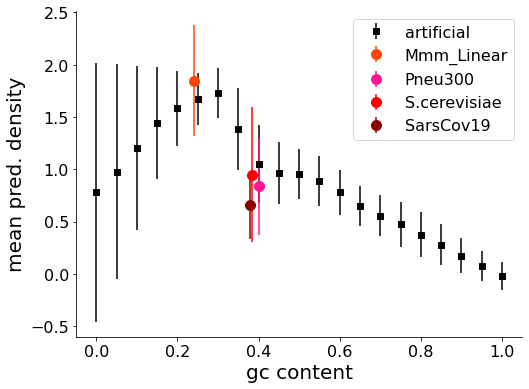

In [28]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/cohesine_myco.npy'),
                                     np.load('./results/bacterial/cohesine_myco_2.npy'),
                                     np.load('./results/bacterial/cohesine_myco_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/cohesine_myco.npy'),
                                          np.load('./results/bacterial/cohesine_myco_2.npy'),
                                          np.load('./results/bacterial/cohesine_myco_3.npy')]))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(np.concatenate([np.load('./results/bacterial/cohesine_pneu.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_2.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/bacterial/cohesine_pneu.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_2.npy'),
                                     np.load('./results/bacterial/cohesine_pneu_3.npy')]))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [mean_coverage_yeast],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[std_coverage_yeast],
             color='red',
             label='S.cerevisiae')

ax.errorbar([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/covid19/chr1.hdf5')],
            [np.mean(np.concatenate([np.load('./results/covid19/cohesine_coverage.npy'),
                                     np.load('./results/covid19/cohesine_coverage_2.npy'),
                                     np.load('./results/covid19/cohesine_coverage_3.npy')]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([np.load('./results/covid19/cohesine_coverage.npy'),
                                         np.load('./results/covid19/cohesine_coverage_2.npy'),
                                         np.load('./results/covid19/cohesine_coverage_3.npy')]))],
             color='darkred',
             label='SarsCov19')
ax.legend(fontsize=16)
#ax.set_xticks(np.arange(0, 1.05, 0.2))
#ax.set_xticklabels(np.round(np.arange(0, 1.05, 0.2), 2), fontsize=16)

#ax.set_yticks(np.arange(-0.1, 0.31, 0.1))
#ax.set_yticklabels(np.round(np.arange(-0.1, 0.31, 0.1), 2), fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)

fig.savefig('./results/gc_content_evolution_cohesine_3.png')

In [ ]:
['chr01', 'chr02', 'chr03', 'chr04',
'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/users/invites/routhier/anaconda3/envs/test

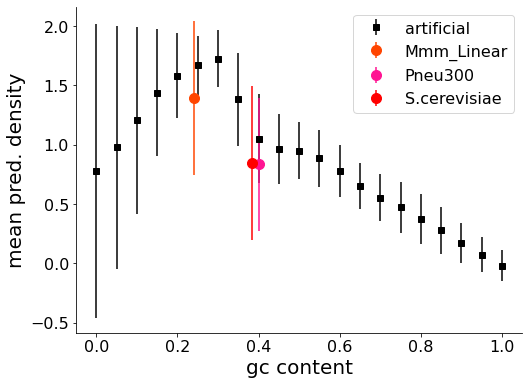

In [41]:
fig = plt.figure(figsize=(8, 6))

markersize = 10

ax = fig.add_subplot(1, 1, 1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.errorbar(np.arange(0, 1.05, 0.05),
            means,
            linestyle='',
            marker='s',
            yerr=stds,
            color='k',
            label='artificial')
ax.errorbar([get_gc_content('./data/bacterie/Mmm_Linear_740kb.hdf5')],
            [np.mean(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(log(myco_coverage_rep1['Mmm_Linear_740kb.fa'] / myco_coverage_rep2['Mmm_Linear_740kb.fa']))],
             color='orangered',
             label='Mmm_Linear')

ax.errorbar([get_gc_content('./data/bacterie/Pneu300.hdf5')],
            [np.mean(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(log(pneu_coverage_rep1['Pneu300'] / pneu_coverage_rep2['Pneu300']))],
             color='deeppink',
             label='Pneu300')

ax.errorbar([gc_content_yeast],
            [np.mean(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             marker='o',
             markersize=markersize,
             linestyle='',
             yerr=[np.std(np.concatenate([log(myco_coverage_rep1[chrom] / myco_coverage_rep2[chrom]) for chrom in ['chr01', 'chr02', 'chr03', 'chr04',
                                                                                                              'chr05', 'chr06', 'chr07', 'chr08', 'chr09', 'chr10',
                                                                                                              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16']]))],
             color='red',
             label='S.cerevisiae')

ax.legend(fontsize=16)
ax.set_xlabel('gc content', fontsize=20)
ax.set_ylabel('mean pred. density', fontsize=20)
fig.savefig('./results/gc_content_evolution_cohesine_experimental.png')

## k-mer proportion of the genome

In [97]:
def return_kmer_from_list(seq):
    dico = {0 : 'N', 1 : 'A', 2 : 'T', 3 : 'G', 4 : 'C'}
    return ''.join(dico[number] for number in seq)

def convert_str(seq):
    dico = {'N' : 0, 'A' : 1, 'T' : 2, 'G' : 3, 'C' : 4}
    return np.array([dico[letter] for letter in seq])

In [108]:
def get_proportion_kmer(array, k, s):
    array = rolling_window(array, window=k, asteps=s)
    unique, counts = np.unique(array, axis=0, return_counts=True)
    df = pd.DataFrame()
    df['kmer'] = np.apply_along_axis(return_kmer_from_list, axis=1, arr=unique)
    df['frequency'] = counts / len(array)
    return df

df = get_proportion_kmer(sequence, k, s)

def create_sequence(length, df, s):
    sequence = np.random.choice(df.kmer.values, p=df.frequency.values)
    
    while len(sequence) < length:
        restricted_df = df[df.kmer.str.startswith(sequence[-s:])].copy()
        restricted_df['frequency'] = restricted_df['frequency'] / restricted_df['frequency'].sum()
        sequence = sequence + np.random.choice(restricted_df.kmer.values, p=restricted_df.frequency.values)[s:]
    return convert_str(sequence[:length])

def random_sequence_kmer(df, s, batch_size=32):
    return np.concatenate([one_hot_encoder(create_sequence(WINDOW, df, s))[None, ...] for _ in range(batch_size)], axis=0)

In [197]:
def shuffle_kmer(seq, kmer):
    cut_seq = rolling_window(seq, window=kmer, asteps=kmer)    
    np.random.shuffle(cut_seq)
    seq_chr = np.concatenate(cut_seq)
    seq_chr_onehot = one_hot_encoder(seq_chr)
    return rolling_window(seq_chr_onehot, (WINDOW, 4), (WINDOW, 4))[:, 0, :, :]

In [182]:
model = keras.models.load_model('./models/weights_myco_rep1_cohesine.hdf5', custom_objects={'correlate' : correlate})

In [239]:
seq_chr_onehot = one_hot_encoder(sequence)
X_test = rolling_window(seq_chr_onehot, (WINDOW, 4), (WINDOW, 4))[:, 0, :, :]

np.mean(model.predict(X_test))

3.8907216

In [236]:
sequence = np.array(h5py.File('./data/bacterie/Mmm_Linear_740kb.hdf5', 'r')['data'])[:, 0]
sequence[sequence == 2] = 5
sequence[sequence == 4] = 2
sequence[sequence == 5] = 4

gc_content_kmer = []
means_kmer = []
stds_kmer = []

for k in range(1, 65512, 2048):
    #df = get_proportion_kmer(sequence, k, s)
    X_test = shuffle_kmer(sequence, k)

    gc_content_kmer.append(get_gc_content_(np.where(np.concatenate(X_test, axis=0) == 1)[1]))
    print('{} : {}'.format(k, np.round(gc_content_kmer[-1], 2)))
    
    predictions = model.predict(X_test)
    means_kmer.append(np.mean(predictions))
    stds_kmer.append(np.std(predictions))

1 : 0.5
2049 : 0.5
4097 : 0.5
6145 : 0.5
8193 : 0.5
10241 : 0.5
12289 : 0.5
14337 : 0.5
16385 : 0.5
18433 : 0.5
20481 : 0.5
22529 : 0.5
24577 : 0.5
26625 : 0.5
28673 : 0.5
30721 : 0.5
32769 : 0.5
34817 : 0.5
36865 : 0.5
38913 : 0.5
40961 : 0.5
43009 : 0.5
45057 : 0.5
47105 : 0.5
49153 : 0.5
51201 : 0.5
53249 : 0.5
55297 : 0.5
57345 : 0.5
59393 : 0.5
61441 : 0.5
63489 : 0.5


In [237]:
means_kmer

[3.8994179,
 3.888499,
 3.8826377,
 3.8877845,
 3.8855252,
 3.8809974,
 3.891727,
 3.890799,
 3.8780167,
 3.8875952,
 3.898482,
 3.901533,
 3.8894947,
 3.882187,
 3.8862648,
 3.8935175,
 3.8917801,
 3.8820405,
 3.8948224,
 3.8810256,
 3.8915968,
 3.8897781,
 3.895813,
 3.881604,
 3.8871717,
 3.8911085,
 3.8791215,
 3.8768525,
 3.8811085,
 3.8865001,
 3.880801,
 3.8902926]

### For legacy

In [ ]:
gc_content_yeast = np.mean([get_gc_content('../Projet_nucleosomes/Programme/seq_chr_sacCer3/W303/chr' + str(i) + '.hdf5') for i in range(1,17)])

In [12]:
import pyBigWig

In [18]:
inputs = read_bed('./data/for_Julien/myco/coverage_RPKM154.bed')
bias = read_bed('./data/for_Julien/myco/coverage_RPKM155.bed')

In [19]:
bw = pyBigWig.open('./data/pneumo_coverage_pol2_log_cpm.bw', 'w')
bw.addHeader([(chrom, size) for chrom, size in yeast_sizes.items()])

for chrom in yeast_sizes.keys():
    values = inputs[chrom] / bias[chrom]
    values[np.isnan(values)] = 0
    values[np.isinf(values)] = np.percentile(values, 99)
    bw.addEntries(chrom, 0, values=list(np.log2(values + 1)), span=1, step=1)
bw.close()

/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/users/invites/routhier/anaconda3/envs/test_env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [22]:
chrom = 'chr06'

In [23]:
bw = pyBigWig.open('./data/pneumo_coverage_pol2_log_cpm.bw')
prediction = np.array(bw.values(chrom, 0, yeast_sizes[chrom]))
bw.close()

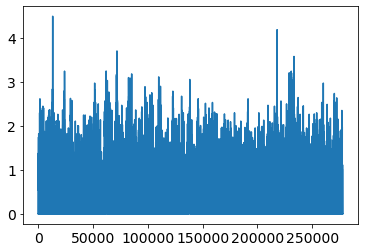

In [24]:
plt.plot(prediction)